# SVM with rbf kernel

The goal of this notebook is to find the best parameters for polynomial kernel. We also want to check if the parameters depend on stock.

We will use [sklearn.svm](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) library to perform calculations. We want to pick the best parameters for **SVC**:

* C (default 1.0)
* gamma (default 1/number_of_features, so 1 in our case)

Kernel function looks like this: $\exp(-\gamma \|x-x'\|^2)$. $\gamma$ is specified by keyword **gamma**, must be greater than 0.

In [1]:
%matplotlib inline
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as md
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn import svm
import warnings

import lob

sns.set_style('whitegrid')

warnings.filterwarnings('ignore')

# Data

We use data from 5 stocks (from dates 2013-09-01 - 2013-11-16) for which logistic regression yielded the best results.

We selected 3 subsets for each stock:
* training set (60% of data)
* test set (20% of data)
* cross-validation set (20% of data)

In [2]:
stocks = ['10795', '12098', '11618', '1243', '11234']

dfs = {}
dfs_cv = {}
dfs_test = {}

for s in stocks:
    df, df_cv, df_test = lob.load_prepared_data(s, cv=True)
    dfs[s] = df
    dfs_cv[s] = df_cv
    dfs_test[s] = df_test

Training set length for 10795: 3030
Testing set length for 10795: 1010
Cross-validation set length for 10795: 1010
Training set length for 12098: 3030
Testing set length for 12098: 1010
Cross-validation set length for 12098: 1010
Training set length for 11618: 3030
Testing set length for 11618: 1010
Cross-validation set length for 11618: 1010
Training set length for 1243: 3030
Testing set length for 1243: 1010
Cross-validation set length for 1243: 1010
Training set length for 11234: 3030
Testing set length for 11234: 1010
Cross-validation set length for 11234: 1010


In [3]:
dfs[stocks[0]].head(5)

,Unnamed: 0,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
1010,2013-09-10 09:34:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1525.0, 1410.0), (1526.0, 3511.0), (1527.0, ...",1523.0,1525.0,1524.0,1410.0,1032.0,1.0,-0.154791
1011,2013-09-10 09:35:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1526.0, 3811.0), (1527.0, 3759.0), (1528.0, ...",1523.0,1526.0,1524.5,3811.0,3889.0,1.0,0.010130
1012,2013-09-10 09:36:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1526.0, 476.0), (1527.0, 3703.0), (1528.0, 6...",1525.0,1526.0,1525.5,476.0,757.0,1.0,0.227899
1013,2013-09-10 09:37:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1527.0, 419.0), (1528.0, 3608.0), (1529.0, 3...",1525.0,1527.0,1526.0,419.0,3116.0,0.0,0.762942
1014,2013-09-10 09:41:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1524.0, 1781.0), (1525.0, 11186.0), (1526.0,...",1523.0,1524.0,1523.5,1781.0,1207.0,1.0,-0.192102


In [4]:
def svm_classification(d, kernel, gamma='auto', C=1.0):
    clf = svm.SVC(kernel=kernel, gamma=gamma, C=C)
    X = d['queue_imbalance'].values.reshape(-1, 1)
    y = d['mid_price_indicator'].values.reshape(-1, 1)
    clf.fit(X, y)
    return clf

# Methodology

We will use at first naive approach to grasp how each of the parameter influences the ROC area score and what values make sense, when the other parameters are set to defaults.

After that we will try to get the best combination of the parameters.

### C parameter

The C parameter has influence over margin picked by SVM:
* for large values of **C** SVM will choose a smaller-margin hyperplane, which means that more data points will be classified correctly
* for small values of **C** SVM will choose a bigger-margin hyperplane, so there may be more misclassifications

At first we tried parameters: [0.0001, 0.001, 0.01, 0.1, 1, 10, 1000], but after first calculations it seems that it wasn't enough, so a few more values were introduced or removed.

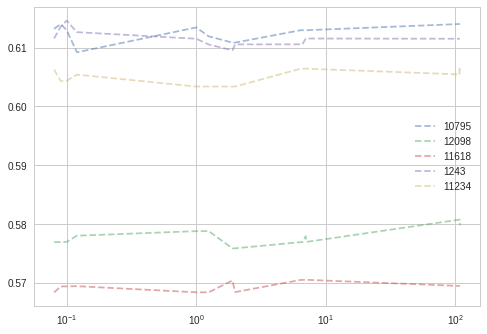

In [6]:
cs = [0.08, 0.09, 0.1, 0.12, 1, 1.25, 1.9, 2, 6.4, 6.5, 6.6, 
      7, 7.1, 107, 108, 
      108.5]
# 0.06, 0.07
# 6.3, 6.7
# 7.2, 7.5, 8, 9
# 109, 110, 111

df_css = {}

ax = plt.subplot()
ax.set_xscale("log", basex=10)
for s in stocks:
    df_cs = pd.DataFrame(index=cs)
    df_cs['roc'] = np.zeros(len(df_cs))
    for c in cs:
        reg_svm = svm_classification(dfs[s], 'rbf', C=c)
        prediction = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))
        score = roc_auc_score(dfs_cv[s]['mid_price_indicator'], prediction)
        df_cs.loc[c] = score
    plt.plot(df_cs, linestyle='--', label=s, marker='x', alpha=0.5)
    df_css[s] = df_cs
    
plt.legend()

##### Best values of C parameter

There is no rule, how to set this parameter.

In [7]:
for s in stocks:
    idx = df_css[s]['roc'].idxmax()
    print('For {} the best is {}'.format(s, idx))

For 10795 the best is 0.09
For 12098 the best is 107.0
For 11618 the best is 7.0
For 1243 the best is 0.1
For 11234 the best is 6.4


##### Influence of C parameter

The score difference between SVM with the worst choice of parameter **C** and the best choice one is shown on the output below. For scoring method we used *roc_area*.

In [8]:
for s in stocks:
    err_max = df_css[s]['roc'].max()
    err_min = df_css[s]['roc'].min()
    print('For {} the diff between best and worst {}'.format(s, err_max - err_min))

For 10795 the diff between best and worst 0.004800787014264674
For 12098 the diff between best and worst 0.004854368932038833
For 11618 the diff between best and worst 0.0021372549019607057
For 1243 the diff between best and worst 0.005039215686274523
For 11234 the diff between best and worst 0.003030303030302939


### Gamma

Gamma is a parameter which has influence over decision region - the bigger it is, the bigger influence every single row of data has. When gamma is low the decision region is very broad. When gamma is high it can even create islands of decision-boundaries around data points.

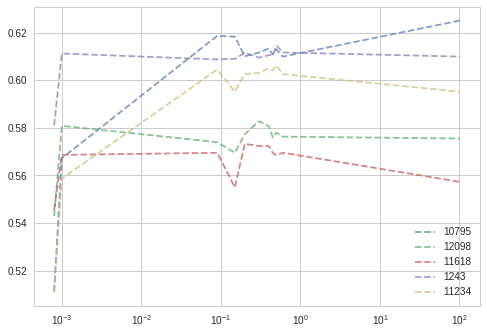

In [9]:
gammas = [0.0008, 0.001, 0.09, 0.15, 0.2, 0.3, 0.4, 0.45, 0.5, 0.6, 100.5, 101, 101.5]

# 0.1
# 102
# 1, 10, 99

df_gammas = {}

ax = plt.subplot()
ax.set_xscale("log", basex=10)
for s in stocks:
    df_gamma = pd.DataFrame(index=gammas)
    df_gamma['roc'] = np.zeros(len(df_gamma))
    for g in gammas:
        reg_svm = svm_classification(dfs[s], 'rbf', gamma=g)
        pred_svm_out_of_sample = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))

        logit_roc_auc = roc_auc_score(dfs_cv[s]['mid_price_indicator'], pred_svm_out_of_sample)
        df_gamma.loc[g] = logit_roc_auc
    plt.plot(df_gamma, linestyle='--', label=s, marker='x', alpha=0.7)
    df_gammas[s] = df_gamma
    
plt.legend()

##### Best values of gamma

There is no rule, how to set this parameter.

In [10]:
for s in stocks:
    idx = df_gammas[s]['roc'].idxmax()
    print('For {} the best is {}'.format(s, idx))

For 10795 the best is 100.5
For 12098 the best is 0.3
For 11618 the best is 0.2
For 1243 the best is 0.5
For 11234 the best is 0.5


##### Influence of gamma

The score difference between SVM with the worst choice of **gamma** and the best choice one is shown on the output below. For scoring method we used *roc_area*. For all stocks the error difference is small - less than 0.04.

In [11]:
for s in stocks:
    err_max = df_gammas[s]['roc'].max()
    err_min = df_gammas[s]['roc'].min()
    print('For {} the diff between best and worst {}'.format(s, err_max - err_min))

For 10795 the diff between best and worst 0.11365469749139212
For 12098 the diff between best and worst 0.03974698440717861
For 11618 the diff between best and worst 0.027764705882352914
For 1243 the diff between best and worst 0.033627450980392215
For 11234 the diff between best and worst 0.09537118760419727


# Results

We compare results of the SVMs with the best choices of parameters against the logistic regression and SVM with defaults.

We will use two approaches for choosing parameters:
* naive - for each stock we will just pick the best values we found in the previous section
* grid - we will caluclate roc_area error for every combination of parameters used in previous section (computionally heavy).

We could also use GridSearchCV from sklearn library, but the issue with it is supplying the cross-validation set (it has to be continous in time). In the future we need to implement the method for that.

#### Naive approach

We pick the best **C** parameter and the best **gamma** separately from the results of [section above](#Methodology), which were obtained using cross-validation set.

In [12]:
df_results = pd.DataFrame(index=stocks)
df_results['logistic'] = np.zeros(len(stocks))
df_results['rbf-naive'] = np.zeros(len(stocks))
df_results['gamma-naive'] = np.zeros(len(stocks))
df_results['c-naive'] = np.zeros(len(stocks))
df_results['rbf-default'] = np.zeros(len(stocks))

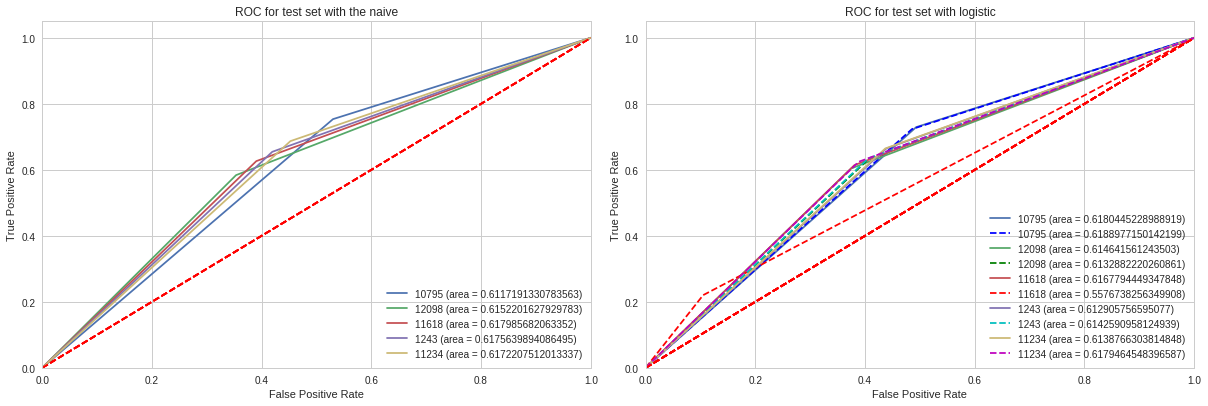

In [13]:
plt.subplot(121)

for s in stocks:
    reg_svm = svm_classification(dfs[s], 'rbf', C=df_css[s]['roc'].idxmax(), 
                                 gamma=df_gammas[s]['roc'].idxmax())
    roc_score = lob.plot_roc(df_test, reg_svm, stock=s, title='ROC for test set with the naive')
    df_results['rbf-naive'][s] = roc_score
    df_results['gamma-naive'][s] = df_gammas[s]['roc'].idxmax()
    df_results['c-naive'][s] = df_css[s]['roc'].idxmax()
    
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plt.subplot(122)
for s in stocks:
    reg_svm = svm_classification(dfs[s], 'rbf')
    roc_score = lob.plot_roc(df_test, reg_svm, stock=s, title='ROC for test set with the defaults')
    df_results['rbf-default'][s] = roc_score
    
    reg_log = lob.logistic_regression(dfs[s], 0, len(dfs[s]))
    roc_score = lob.plot_roc(df_test, reg_log, stock=s, title='ROC for test set with logistic', 
                             c=colors[stocks.index(s)], linestyle='--')
    df_results['logistic'][s] = roc_score

plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

In [14]:
df_results

,logistic,rbf-naive,gamma-naive,c-naive,rbf-default
10795,0.618898,0.611719,100.5,0.09,0.618045
12098,0.613288,0.615220,0.3,107.00,0.614642
11618,0.557674,0.617986,0.2,7.00,0.616779
1243,0.614259,0.617564,0.5,0.10,0.612906
11234,0.617946,0.617221,0.5,6.40,0.613877


### Grid approach

We iterate over all combinations of parameters **C** and **gamma**.

This approach works usually better, but not for all cases.

In [15]:
df_params = {}

for s in stocks:
    print(s)
    params = []
    for c in cs:
        for g in gammas:
            reg_svm = svm_classification(dfs[s], 'rbf', C=c, gamma=g)
            prediction = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))
            score = roc_auc_score(dfs_cv[s]['mid_price_indicator'], prediction)
            params.append({'score': score, 'gamma': g, 'c': c})
    df_params[s] = pd.DataFrame(params)

10795
12098
11618
1243
11234


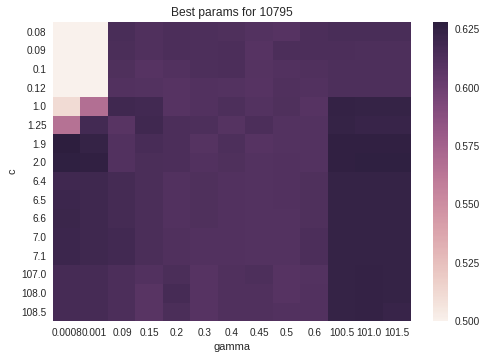

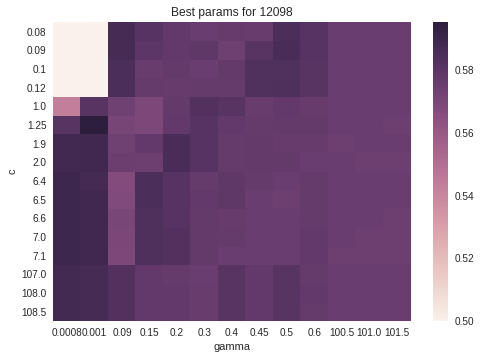

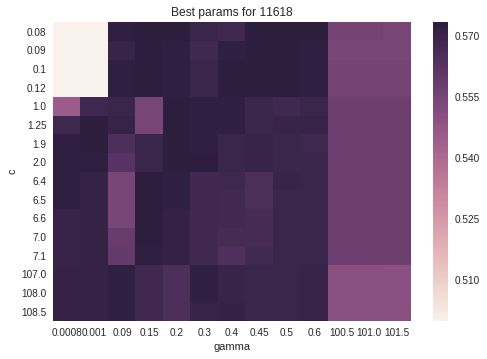

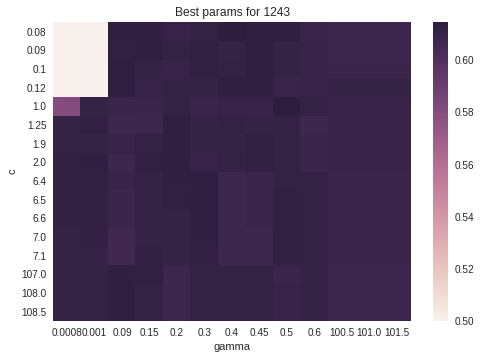

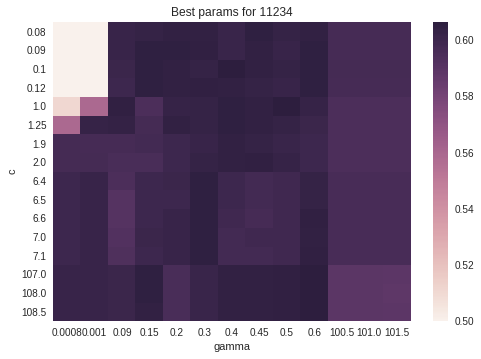

In [16]:
for s in stocks:
    df_g = df_params[s].pivot(index='c', columns='gamma', values='score')
    sns.heatmap(df_g)
    plt.title('Best params for ' + s)
    plt.figure()

##### Best parameters for grid approach

In [17]:
for s in stocks:
    print(s, df_params[s].iloc[df_params[s]['score'].idxmax()])

10795 c        1.900000
gamma    0.000800
score    0.628067
Name: 78, dtype: float64
12098 c        1.250000
gamma    0.001000
score    0.595224
Name: 66, dtype: float64
11618 c        2.000000
gamma    0.300000
score    0.573353
Name: 96, dtype: float64
1243 c        0.080000
gamma    0.400000
score    0.614569
Name: 6, dtype: float64
11234 c        0.100000
gamma    0.400000
score    0.606414
Name: 32, dtype: float64


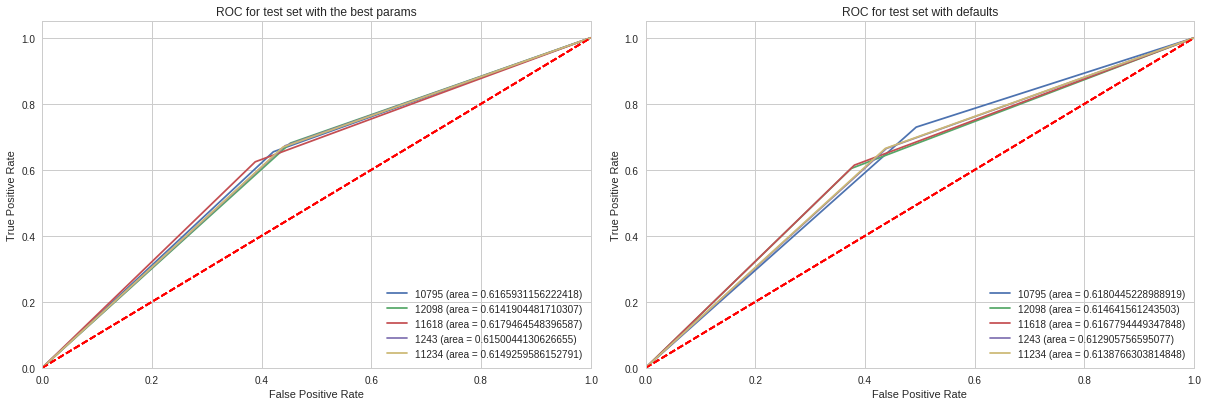

In [18]:
df_results['rbf-grid'] = np.zeros(len(stocks))
df_results['c-grid'] = np.zeros(len(stocks))
df_results['gamma-grid'] = np.zeros(len(stocks))
plt.subplot(121)
for s in stocks:
    best_idx = df_params[s]['score'].idxmax()
    reg_svm = svm_classification(dfs[s], 'rbf', C=df_params[s].iloc[best_idx]['c'], 
                                 gamma=df_params[s].iloc[best_idx]['gamma'])
    roc_score = lob.plot_roc(df_test, reg_svm, stock=s, title='ROC for test set with the best params')
    df_results['rbf-grid'][s] = roc_score
    df_results['gamma-grid'][s] = df_params[s].iloc[best_idx]['gamma']
    df_results['c-grid'][s] = df_params[s].iloc[best_idx]['c']

plt.subplot(122)
for s in stocks:
    reg_svm = svm_classification(dfs[s], 'rbf')
    prediction = reg_svm.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
    roc_score = lob.plot_roc(df_test, reg_svm, stock=s, title='ROC for test set with defaults')
    df_results['rbf-default'][s] = roc_score
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

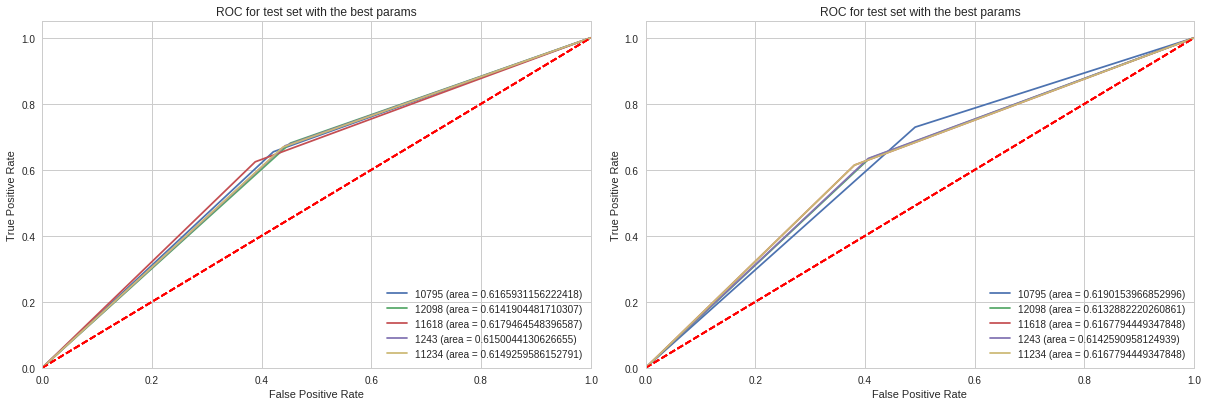

In [19]:
plt.subplot(121)
for s in stocks:
    best_idx = df_params[s]['score'].idxmax()
    reg_svm = svm_classification(dfs[s], 'rbf', C=df_params[s].iloc[best_idx]['c'], 
                                 gamma=df_params[s].iloc[best_idx]['gamma'])
    roc_score = lob.plot_roc(df_test, reg_svm, stock=s, title='ROC for test set with the best params')
    df_results['rbf-grid'][s] = roc_score

plt.subplot(122)
for s in stocks:
    reg_log = lob.logistic_regression(dfs[s], 0, len(dfs[s]))
    roc_score = lob.plot_roc(df_test, reg_log, stock=s, title='ROC for test set with the best params')
    df_results['logistic'][s] = roc_score

plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

In [20]:
df_results[['logistic', 'rbf-naive', 'rbf-default', 'rbf-grid']]

,logistic,rbf-naive,rbf-default,rbf-grid
10795,0.619015,0.611719,0.618045,0.616593
12098,0.613288,0.615220,0.614642,0.614190
11618,0.616779,0.617986,0.616779,0.617946
1243,0.614259,0.617564,0.612906,0.615004
11234,0.616779,0.617221,0.613877,0.614926


In [21]:
df_results

,logistic,rbf-naive,gamma-naive,c-naive,rbf-default,rbf-grid,c-grid,gamma-grid
10795,0.619015,0.611719,100.5,0.09,0.618045,0.616593,1.90,0.0008
12098,0.613288,0.615220,0.3,107.00,0.614642,0.614190,1.25,0.0010
11618,0.616779,0.617986,0.2,7.00,0.616779,0.617946,2.00,0.3000
1243,0.614259,0.617564,0.5,0.10,0.612906,0.615004,0.08,0.4000
11234,0.616779,0.617221,0.5,6.40,0.613877,0.614926,0.10,0.4000


# Conclusions


The **C** parameter for **rbf** kernel should be choosen for each stock separately. The choice of **C** paramter matters - the difference between roc_area scoring between the worst and best case is about $0.1$ for each stock of this choice. The only thing in common is that C should be bigger than $0.0001$. But suprisingly only for one of the stock data - the bigger **C** the better.

### Resources

1. [Queue Imbalance as a One-Tick-Ahead Price Predictor in a Limit Order Book](https://arxiv.org/abs/1512.03492) <a class="anchor-link" href="#1">¶</a>
2. [RBF kernel](https://chrisalbon.com/machine_learning/support_vector_machines/svc_parameters_using_rbf_kernel/)
3. [model_selection.GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)